In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simpson, quad, trapezoid
from scipy.optimize import root

In [2]:
# Constants with uncertainties
hbarc = 197.3269631 # MeV fm
mc2 = 939.56542052 # MeV

lower_bound = np.ceil(np.pi**2 * hbarc**2/(8*mc2))
upper_bound = np.floor(9*np.pi**2 * hbarc**2/(8*mc2))
print("Lower Bound: ",lower_bound)
print("Upper Bound: ",upper_bound)

Lower Bound:  52.0
Upper Bound:  460.0


$52 \leq V_0L^2 \leq 460$

In [3]:
#Even - parity solutions
def even_solution_lhs(x):
    return -x / np.tan(x)

#Right side of transedental equation
def even_solution_rhs(x, V0, L):
    A = (2 * mc2 * V0 * L) / (hbarc ** 2)
    xmax = np.sqrt(A)
    x_safe = np.minimum(x, xmax - 1e-10)
    return np.sqrt(A - x_safe**2)

# Function to find the roots of the equation
def transcendental_eq(x, V0, L):
    lhs = even_solution_lhs(x)
    rhs = even_solution_rhs(x, V0, L)
    return rhs - lhs

## Ploting transcedental equation

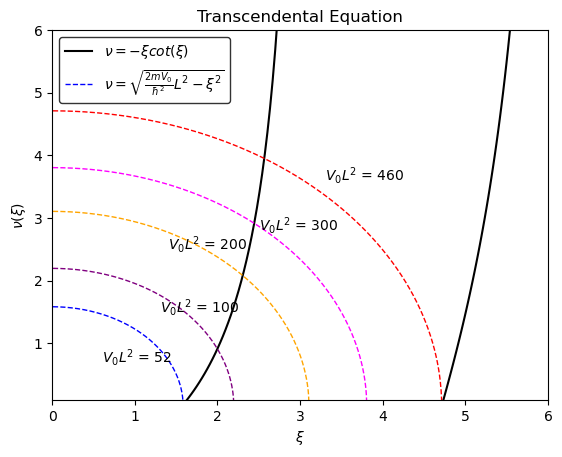

In [10]:
ksi = np.linspace(0.01, 5, 1000)
xPlot1 = np.linspace(0.01,np.pi,100)
xPlot2 = np.linspace(4, 6,100)

plt.plot(xPlot1,even_solution_lhs(xPlot1), color='k', label=r'$ \nu = - \xi cot( \xi)$')
plt.plot(xPlot2,even_solution_lhs(xPlot2), color='k')

plt.plot(ksi,even_solution_rhs(ksi,52,1), linewidth=1 ,linestyle='--', color='blue', label=r'$ \nu = \sqrt{\frac{2mV_0}{\hbar^2}L^2 - \xi^2}$')
plt.text(0.6, 0.7, r'$V_0L^2$ = 52')
plt.plot(ksi,even_solution_rhs(ksi,100,1), linewidth=1 ,linestyle='--', color='purple')
plt.text(1.3, 1.5, r'$V_0L^2$ = 100')
plt.plot(ksi,even_solution_rhs(ksi,200,1), linewidth=1 ,linestyle='--', color='orange')
plt.text(1.4, 2.5, r'$V_0L^2$ = 200')
plt.plot(ksi,even_solution_rhs(ksi,300,1), linewidth=1 ,linestyle='--', color='magenta')
plt.text(2.5, 2.8, r'$V_0L^2$ = 300')
plt.plot(ksi,even_solution_rhs(ksi,460,1), linewidth=1 ,linestyle='--', color='red')
plt.text(3.3, 3.6, r'$V_0L^2$ = 460')

plt.ylim([0.1, 6])
plt.xlim([0, 6])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\nu ( \xi)$')
plt.title('Transcendental Equation')
plt.legend(frameon=True, edgecolor='black', fontsize=10)
plt.show()

### Store the computed energy in the ```df``` variable when we have 10% error or smaller

In [11]:
l_val = np.arange(1, 4.01, 0.01)
Eb = 2.224
E_lower = Eb * 0.9
E_upper = Eb * 1.1

In [63]:
res = []

for l in l_val:
    L2 = l**2
    Vl = lower_bound / L2
    Vu = upper_bound / L2
    v_values = np.linspace(Vl, Vu, 100 )

    for v in v_values:
        sol = root(transcendental_eq, 1.0, args=(v, L2))
        if sol.success:
            ksi = sol.x[0]
            E = v - (hbarc**2 * ksi**2) / (2 * mc2 * L2)
            if E_lower <= E <= E_upper:
                res.append({'V0': v, 'L2': L2, 'E': abs(E)})

df = pd.DataFrame(res)
df.head(5)

,V0,L2,E
0,56.599048,1.2100,2.413585
1,55.583839,1.2321,2.370293
2,54.595702,1.2544,2.328155
3,53.633682,1.2769,2.287131
4,52.696867,1.2996,2.247182


### Mean value of E

In [19]:
round(float(np.mean(df['E'])),5)

2.22125

## Compute the Radius

In [20]:
def rms_Radius(V0, E, L):


    k = np.sqrt(2 * mc2 * E) / hbarc
    gamma = np.sqrt(2 * mc2 * (V0 - E)) / hbarc

    # Normalization constant A
    norm_term = (L / 2) - (np.sin(2 * k * L) / (4 * k)) + (np.sin(k * L) ** 2) / (2 * gamma)
    A = 1 / np.sqrt(norm_term)

    # Amplitude B
    B = A * np.sin(k * L) * np.exp(gamma * L)

    # Integrands
    def integrand_inside(r):
        return np.sin(k * r) ** 2 * r ** 2

    def integrand_outside(r):
        return np.exp(-2 * gamma * r) * r ** 2

    # Integrate
    I1, _ = quad(integrand_inside, 0, L, limit=100)
    I2, _ = quad(integrand_outside, L, np.inf, limit=100)

    # Final ⟨r^2⟩ and sqrt⟨r^2⟩
    r2_mean = 4 * np.pi * (A ** 2 * I1 + B ** 2 * I2)
    return np.sqrt(r2_mean), A, B, k, gamma

In [64]:
radius_results = []

for _, row in df.iterrows():
    V0 = row['V0']
    L = np.sqrt(row['L2'])
    E = row['E']

    R,_,_,_,_ = rms_Radius(V0, E, L)

    if 1 < R < 10:
        radius_results.append({
            'V0': V0,
            'L2': row['L2'],
            'E': E,
            'R': R
        })

df_final = pd.DataFrame(radius_results)
df_final.head(5)

,V0,L2,E,R
0,56.599048,1.2100,2.413585,4.099790
1,55.583839,1.2321,2.370293,4.137061
2,54.595702,1.2544,2.328155,4.174332
3,53.633682,1.2769,2.287131,4.211603
4,52.696867,1.2996,2.247182,4.248874


In [25]:
radii = []
for i in range(df.shape[0]-1):
    r = rms_Radius(df['V0'][i],np.sqrt(df['L2'][i]),df['E'][i])
    if 1<r[0] and r[0]<10:
        radii.append({'V0': df['V0'][i], 'L2': df['L2'][i], 'E': df['E'][i], 'R': r[0]})
df_final = pd.DataFrame(radii)

### Mean value of R

In [28]:
round(float(np.mean(df_final['R'])),5)

8.61492

## Compute the wavefunction

In [61]:
def plot_wavefunction(V0, L2, E, r_range=(0.001, 20), color='magenta', label_pos=(7.5, 0.8)):

    L = np.sqrt(L2)
    R, A, B, k, g = rms_Radius(V0, L, E)

    # Define the wavefunction
    def h(r):
        y = np.zeros_like(r)
        mask = (r > 0) & (r < L)
        y[mask] = A * np.sin(k * r[mask])
        y[~mask] = B * np.exp(-g * r[~mask])
        return y

    # Evaluate and plot
    r_vals = np.linspace(*r_range, 400)
    y_vals = h(r_vals)

    plt.plot(r_vals, y_vals, linewidth=1.2, color=color)
    plt.plot([3.2, 5],[0.7, 0.8], linewidth=1.2, color='k')
    plt.text(*label_pos, 
             r'$V_0 = {:.2f}$'.format(V0) + '\n' + 
             r'$L = {:.3f}$'.format(L),
             fontsize=13,
             ha='center',
             va='center',
             bbox=dict(facecolor='white', boxstyle='round,pad=0.5'))
    
    plt.title('Radial Wavefunction', fontsize=14)
    plt.xlabel(r'$r$ [fm]', fontsize=12)
    plt.ylabel(r'$\eta(r)$', fontsize=12)
    plt.grid(True)
    plt.show()
    
    dxt = r_vals[1]-r_vals[0] # dx
    I_simpson = simpson(y_vals**2, dx=dxt)
    print(f'Simpson’s Rule: (wavefunction)^2 = {I_simpson:.4f}')

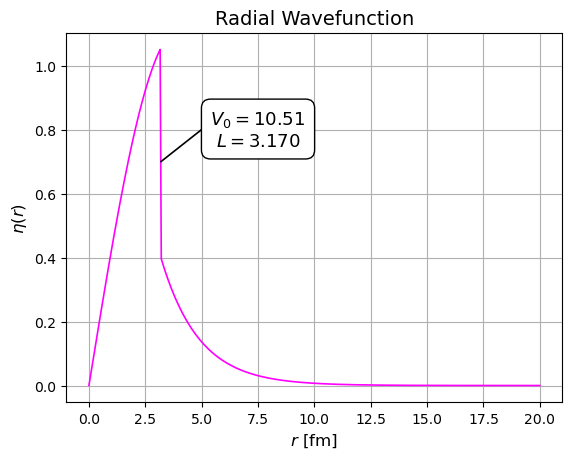

Simpson’s Rule: (wavefunction)^2 = 1.6330


In [62]:
a = df_final[(df_final['R'] > 8.61) & (df_final['R'] < 8.6169)]
row = df_final.loc[a.index]
plot_wavefunction(row.iloc[0]['V0'], row.iloc[0]['L2'], row.iloc[0]['E'])
